# **Amazon Fine Food Review, Sentiment Analysis using Machine Learning technique LOgistic Regression**

About Database- All data in one sqlite database. 568,454 food reviews Amazon users left up to October 2012 Overview- 
1) In this project, we have 568k * 10 size dataset. i.e. 568k rows and 10 columns(features).

 2) In this dataset, we have 10 features which are as follows-
  i) Id-Row Id
 ii) ProductId- Unique identifier for the product iii) UserId- Unqiue identifier for the user 
 iv) ProfileName- Profile name of the user 
 v) HelpfulnessNumerator- Number of users who found the review helpful
 vi) HelpfulnessDenominator- Number of users who indicated whether they found the review helpful or not 
 vii) Score- Rating between 1 and 5 
 viii) Time- Timestamp for the review 
 ix) Summary- Brief summary of the review x) Text- Text of the review

 objective of this project is to predict whether given new review is positive or negative.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score
import sqlite3

In [2]:
#  read data
con=sqlite3.connect('/content/drive/MyDrive/amazon data/database.sqlite')

In [3]:
# we neglect the review having Score = 3
filtered_data=pd.read_sql_query(''' SELECT * FROM Reviews WHERE Score!=3''',con)

In [4]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
def partition(x):
  if x<3:
    return 'negetive'
  return 'positive'

In [6]:
filtered_data['Score']=filtered_data['Score'].map(partition)

In [7]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negetive,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
filtered_data['Score'].value_counts()

positive    443777
negetive     82037
Name: Score, dtype: int64

In [9]:
#EDA

display=pd.read_sql_query('''SELECT * FROM Reviews WHERE Score!=3
                              AND UserId="AR5J8UI46CURR"
                              ORDER BY ProductID''',con)

In [10]:
print(display.shape)
display.head()

(5, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...





*Observations: *

1) As in above table, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator.Score,Time, Summary and Text shows same content

2) Also for all 5 product, shows same time.

3) Here we observed that, product is same, only the flavour is different

4) so we will remove this duplication and keep any one product which all these features so we removing duplicates.


In [11]:
#sort data according to ProductId in ascending order#
sorted_data=filtered_data.sort_values('ProductId',ascending=True,inplace=False,kind='quicksort',na_position='last')


In [12]:
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)

In [13]:
final.shape

(364173, 10)

In [14]:
#After removing duplications, we will see how much % of data still remains

((final['Id'].size)/(filtered_data['Id'].size))*100

69.25890143662969

In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

## **Now, we do preprocessing like removal of stop words, html tags and make all letters in lowercase.**

In [16]:
import re
i=0
for sent in final['Text'].values:
  if (re.findall('<.*?>',sent)):
    print(i)
    print(sent)
    break
  i+=1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [17]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
stop=set(stopwords.words('english')) #set of stopwords
sno= nltk.stem.SnowballStemmer('english') #     # initialising snowball stemmer

In [20]:
#function to clean html tags

def cleanhtml(sentence):
  cleanr=re.compile('<.*?>')
  cleantext=re.sub(cleanr,'',sentence)
  return cleantext

#function to build punctuations
def cleanpunc(sentence):
  cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
  cleaned=re.sub(r'[.|,|(|)|\|/]',r'', cleaned)
  return cleaned


In [21]:
print(stop)
print(sno.stem('tasty'))

{'him', 'nor', 'her', 'me', "you're", 'm', 'because', 'has', 'how', "haven't", "wasn't", 'a', 'having', 'from', 'have', 'whom', 'doing', 'your', 'hasn', 'had', 'again', 'we', 'ours', "you'll", 'were', 'will', 't', "mustn't", 'it', 'most', 'why', 'doesn', 'above', 'own', 'what', 'you', 'yourself', 'being', 'over', 'further', 'he', 'mustn', 'am', 'are', 're', 'themselves', 'my', 'during', 'aren', 'these', 'that', "aren't", 'but', 'didn', 'by', "should've", 'is', 'theirs', 'each', 'the', 'should', 'his', 'before', 'after', 'she', 'shan', 'any', 'yourselves', 'more', 'just', "wouldn't", 'and', 'y', 'this', 'to', 'down', 'all', 'himself', 'ma', 'at', 'was', 'its', "you've", 'once', 'not', "don't", "didn't", 'needn', 'very', "shouldn't", 'itself', 'in', 'no', 's', 'been', 'be', 'does', 'under', 'such', "it's", 'both', "weren't", 'few', 'ourselves', 'here', 'out', "hasn't", 'won', "she's", 'while', 'on', 'couldn', 'than', "doesn't", 'do', 'of', 'd', 'an', 'don', 'mightn', 'who', 'now', 'can',

In [22]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

i=0
final_string=[]
all_positive_words=[]
all_negetive_words=[]
str1=''
s=''
for sent in final['Text'].values:
  filtered_sentence=[]
  sent=cleanhtml(sent)
  
  for w in sent.split():
    for cleanword in cleanpunc(w).split():
      if ((cleanword.isalpha()) & (len(cleanword)>2)):
        if (cleanword.islower() not in stop):
          s=(sno.stem(cleanword.lower()))
          filtered_sentence.append(s)
          if (final['Score'].values)[i]=='positive':
            all_positive_words.append(s)
          if (final['Score'].values)[i]=='negetive':
            all_negetive_words.append(s)
        else:
          continue
      else:
        continue
  str1=' '.join(filtered_sentence)

  final_string.append(str1)
  i+=1


In [23]:
final['CleanText']=final_string

In [24]:
final.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,this witti littl book make son laugh loud reci...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read these sendak book and watch the real...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,this fun way for children learn their month th...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,this great littl book read has nice rhythm wel...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,this book poetri about the month the year goe ...
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci...",charm rhyme book that describ the circumst und...
138694,150512,0006641040,A1DJXZA5V5FFVA,A. Conway,0,0,positive,1338249600,Must have.,I set aside at least an hour each day to read ...,set asid least hour each day read son this poi...
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,positive,1325721600,A classic,I remembered this book from my childhood and g...,rememb this book from childhood and got for ki...
138696,150514,0006641040,A2ONB6ZA292PA,Rosalind Matzner,0,0,positive,1313884800,Chicken soup with Rice,It's a great book with adorable illustrations....,it great book with ador illustr true classic k...
138697,150515,0006641040,A2RTT81R6Y3R7X,Lindylu,0,0,positive,1303171200,One of our family's favorite books,This book is a family favorite and was read to...,this book famili favorit and was read children...


In [25]:
final['Time']=pd.to_datetime(final['Time'],unit='s')

final=final.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
final.shape

(364171, 11)

In [26]:
final_p =final[final['Score']=='positive'].sample(n=10000)
final_n =final[final['Score']=='negetive'].sample(n=10000)
final=pd.concat([final_p,final_n])

In [28]:
!pip3 install scikit-plot

In [29]:
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import  roc_auc_score,f1_score,accuracy_score,hamming_loss
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [261]:
from sklearn.model_selection import train_test_split
X=final['CleanText']
y=final['Score']

In [262]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=y,random_state=0)


## **Training model**

In [263]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

#logistic regression with l1 penalty
def logistic_l1(X_train,X_test,y_train,y_test):
  cv_scores=[]
  C=[10**-4,10**-2,10**0,10**2,10**4]
  for i in C:
    model=LogisticRegression(penalty='l1',solver='liblinear',C=i)
    model.fit(X_train,y_train)
    scores=cross_val_score(model,X_train,y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())
    optimal_c=C[cv_scores.index(max(cv_scores))]
  
  #plot accuracy vs alpha
  plt.plot(C,cv_scores,label='TrainAUC')
  plt.xlabel('Hyper parameter')
  plt.ylabel(' Area under Roc curve')
  plt.title('AUC vs Hyper parameter')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

  fpr,tpr,thrshold=metrics.roc_curve(y_test,model.predict_proba(X_test)[:,1],pos_label='positive')
  auc=metrics.auc(fpr,tpr)
  
  print(f' optimal C is {optimal_c} with best roc score is {auc}')

 


  

In [264]:
from sklearn.linear_model import LogisticRegression

#logistic regression with l2 penalty
def logistic_l2(X_train,X_test,y_train,y_test):
  cv_scores=[]
  C=[10**-4,10**-2,10**0,10**2,10**4]
  for i in C:
    model=LogisticRegression(penalty='l2',C=i)
    model.fit(X_train,y_train)
    scores=cross_val_score(model,X_train,y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())
    optimal_c=C[cv_scores.index(max(cv_scores))]
  
  #plot accuracy vs alpha
  plt.plot(C,cv_scores,label='TrainAUC')
  plt.xlabel('Hyper parameter')
  plt.ylabel(' Area under Roc curve')
  plt.title('AUC vs Hyper parameter')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

  fpr,tpr,threshold=metrics.roc_curve(y_test,model.predict_proba(X_test)[:,1],pos_label='positive')
  auc=metrics.auc(fpr,tpr)
  
  
  print(f' optimal C is {optimal_c} with best roc score is {auc}')

  return optimal_c




# **Testing model**



In [265]:
def testingmodel_l1(X_train,X_test,y_train,y_test,optimal_c):
  log1=LogisticRegression(C=optimal_c,penalty='l1',solver='liblinear')
  log1.fit(X_train,y_train)
  pred=log1.predict(X_test)

  print('Test data report')
  print('Best c',optimal_c)
  
  skplt.metrics.plot_confusion_matrix(y_test,pred)
  plt.show()
  print("macro f1 score for data :",metrics.f1_score(y_test, pred, average = 'macro'))
  print("micro f1 scoore for data:",metrics.f1_score(y_test, pred, average = 'micro'))
  print("hamming loss for data:",metrics.hamming_loss(y_test,pred))
  print("Precision recall report for data:\n",metrics.classification_report(y_test, pred))


  fpr,tpr,threshold=metrics.roc_curve(y_test,log1.predict_proba(X_test)[:,1],pos_label='positive')
  fpr2,tpr2,threshold2=metrics.roc_curve(y_train,log1.predict_proba(X_train)[:,1],pos_label='positive')
  auc=metrics.auc(fpr,tpr)
  auc1=metrics.auc(fpr2,tpr2)
  print('Test  auc',auc)
  print('Train auc',auc1)
  plt.title('Roc Curve')
  plt.plot(fpr,tpr,label='AUC =%.2f'%auc)
  plt.plot(fpr2,tpr2,label='AUC=%.2f'%auc1)
  plt.legend(['TEst data','Train data'],loc='best')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.show()


In [266]:
def testingmodel_l2(X_train,X_test,y_train,y_test,optimal_c):
  log1=LogisticRegression(C=optimal_c,penalty='l2')
  log1.fit(X_train,y_train)
  pred=log1.predict(X_test)

  print('Test data report')
  print('Best c',optimal_c)
  skplt.metrics.plot_confusion_matrix(y_test,pred)

  plt.show()
  print("macro f1 score for data :",metrics.f1_score(y_test, pred, average = 'macro'))
  print("hamming loss for data:",metrics.hamming_loss(y_test,pred))
  print("Precision recall report for data:\n",metrics.classification_report(y_test, pred))
 
  fpr,tpr,threshold=metrics.roc_curve(y_test,log1.predict_proba(X_test)[:,1],pos_label='positive')
  fpr2,tpr2,threshold2=metrics.roc_curve(y_train,log1.predict_proba(X_train)[:,1],pos_label='positive')
  auc=metrics.auc(fpr,tpr)
  auc1=metrics.auc(fpr2,tpr2)
  print('Test  auc',auc)
  print('Train auc',auc1)

  plt.title('Roc Curve')
  plt.plot(fpr,tpr,label='AUC =%.3f'%auc)
  plt.plot(fpr2,tpr2,label='AUC=%.3f'%auc1)
  plt.legend(['TEst data','Train data'],loc='best')

  plt.plot([0,1],[0,1],'r--')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.show()


## **Top 10 features**

In [267]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

## **Techiques of vectorization**

# Bag Of Words (BOW) 

In [268]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer()
bow_train=count_vect.fit_transform(X_train)
bow_test=count_vect.transform(X_test)
print('Cv data size',bow_train.shape)
print('test data size',bow_test.shape)


Cv data size (14000, 24859)
test data size (6000, 24859)


In [269]:
#normalize the data
from sklearn.preprocessing import StandardScaler
sc= StandardScaler(with_mean=False)
bow_train=sc.fit_transform(bow_train)

bow_test=sc.transform(bow_test)
print('Cv data size',bow_train.shape)
print('test data size',bow_test.shape)

Cv data size (14000, 24859)
test data size (6000, 24859)


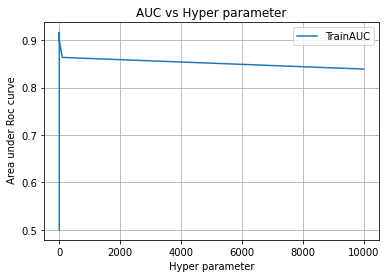

 optimal C is 0.01 with best roc score is 0.8414893888888888


In [270]:
logistic_l1(bow_train,bow_test,y_train,y_test)

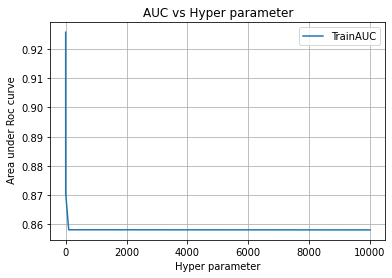

 optimal C is 0.0001 with best roc score is 0.8636125555555556


0.0001

In [271]:
logistic_l2(bow_train,bow_test,y_train,y_test)

Test data report
Best c 0.01


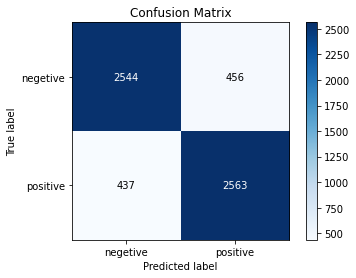

macro f1 score for data : 0.8511651741841078
micro f1 scoore for data: 0.8511666666666666
hamming loss for data: 0.14883333333333335
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.85      0.85      0.85      3000
    positive       0.85      0.85      0.85      3000

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000

Test  auc 0.9211597777777778
Train auc 0.9400618265306121


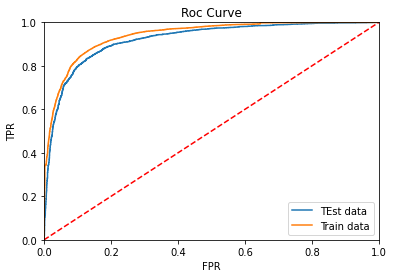

In [272]:
testingmodel_l1(bow_train,bow_test,y_train,y_test,optimal_c=0.01)

Test data report
Best c 0.0001


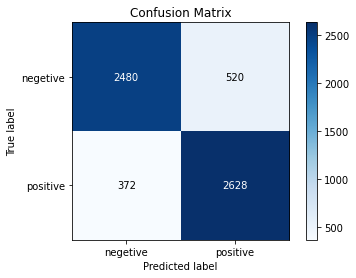

macro f1 score for data : 0.8512428228553284
hamming loss for data: 0.14866666666666667
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.87      0.83      0.85      3000
    positive       0.83      0.88      0.85      3000

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000

Test  auc 0.9210546666666667
Train auc 0.9943011428571429


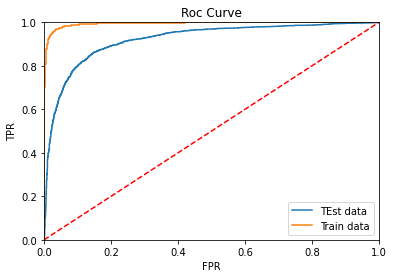

In [273]:
testingmodel_l2(bow_train,bow_test,y_train,y_test,optimal_c=0.0001)

In [274]:
#Top 10 important features of L1 regularization
clf=LogisticRegression(C=0.01,solver='liblinear', penalty='l1')
clf.fit(bow_train,y_train)
show_most_informative_features(count_vect,clf)

	-0.3839	not            		0.4276	great          
	-0.3277	disappoint     		0.3300	best           
	-0.2081	was            		0.3254	love           
	-0.1886	horribl        		0.2405	good           
	-0.1791	return         		0.2388	perfect        
	-0.1754	worst          		0.2372	delici         
	-0.1628	aw             		0.1833	nice           
	-0.1540	tast           		0.1344	excel          
	-0.1500	unfortun       		0.1331	wonder         
	-0.1342	stale          		0.1314	keep           


In [275]:
clf2=LogisticRegression(penalty='l2',C=0.0001)
clf2.fit(bow_train,y_train)
show_most_informative_features(count_vect,clf2)

	-0.0627	not            		0.0773	great          
	-0.0611	disappoint     		0.0634	love           
	-0.0430	was            		0.0500	best           
	-0.0370	wast           		0.0462	delici         
	-0.0365	money          		0.0436	perfect        
	-0.0361	bad            		0.0336	good           
	-0.0358	worst          		0.0330	nice           
	-0.0355	aw             		0.0319	favorit        
	-0.0352	return         		0.0308	easi           
	-0.0337	terribl        		0.0305	excel          


## Sparsity in L1 Regularization

In [276]:
def sparsity(X_train,y_train,X_test,y_test):
  C=[10**-4,10**-2,10**0,10**2,10**4]
  for i in C:
    lr=LogisticRegression(penalty='l1',solver='liblinear',C=i)
    lr.fit(X_train,y_train)
    pred=lr.predict(X_test)
    print('C value -', i  ,'ll value is =l1')
    
    print('Non zero weight',np.count_nonzero(lr.coef_))
    print('-'*50)

In [277]:
sparsity(bow_train,y_train,bow_test,y_test)

C value - 0.0001 ll value is =l1
Non zero weight 0
--------------------------------------------------
C value - 0.01 ll value is =l1
Non zero weight 641
--------------------------------------------------
C value - 1 ll value is =l1
Non zero weight 6581
--------------------------------------------------
C value - 100 ll value is =l1
Non zero weight 10545
--------------------------------------------------
C value - 10000 ll value is =l1
Non zero weight 14641
--------------------------------------------------


## **Pertubation Test BOW**

In [278]:
from scipy.sparse import find
model=LogisticRegression(penalty='l2',C=0.0001)
model.fit(bow_train,y_train)
weights=find(model.coef_[0])[2]  #weights before adding noise
print('Non zero weeighs',np.count_nonzero(model.coef_))

Non zero weeighs 24859


In [279]:
bow_train_noise=bow_train
epsilon=np.random.uniform(low=-0.00001,high=0.00001,size=(find(bow_train_noise)[0].size))
a,b,c=find(bow_train_noise)
bow_train_noise[a,b]=epsilon+bow_train[a,b]


In [280]:
model2=LogisticRegression(C=0.0001,penalty='l2')
model2.fit(bow_train_noise,y_train)
weights2=find(model2.coef_[0])[2]
print('Non zero weights',np.count_nonzero(weights2))


Non zero weights 24859


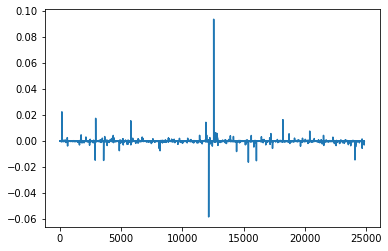

In [281]:
percentage_change_vector=(abs(weights-weights2)/(weights))*100
plt.plot(percentage_change_vector)

In [282]:
print(percentage_change_vector[np.where(percentage_change_vector>0.10)].size)

0


## Top collinear featues after perbutraion test

In [283]:
index=np.argsort(np.abs(weights-weights2))[::-1]
features=count_vect.get_feature_names()
features=np.array(features)
a=features[index]
print(a[:10])

['dont' 'too' 'they' 'the' 'much' 'this' 'and' 'was' 'more' 'love']


# TFIDF

In [284]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
tfidf_train=tf_idf_vect.fit_transform(X_train)
tfidf_test=tf_idf_vect.transform(X_test)
print('Train data size',tfidf_train.shape)
print('Test data size',tfidf_test.shape)

Train data size (14000, 330723)
Test data size (6000, 330723)


In [285]:
#Normalize data
sc=StandardScaler(with_mean=False)
tfidf_train=sc.fit_transform(tfidf_train)
tfidf_test=sc.transform(tfidf_test)
print('The shape of tfidf vectorizer',tfidf_train.get_shape())
print('Test data size',tfidf_test.shape)

The shape of tfidf vectorizer (14000, 330723)
Test data size (6000, 330723)


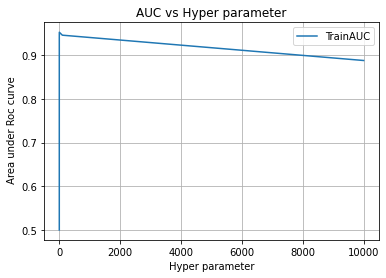

 optimal C is 1 with best roc score is 0.9019159999999999


In [286]:
logistic_l1(tfidf_train,tfidf_test,y_train,y_test)

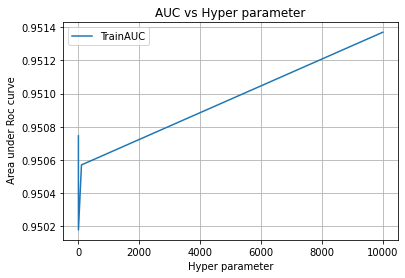

 optimal C is 10000 with best roc score is 0.948011888888889


10000

In [287]:
logistic_l2(tfidf_train,tfidf_test,y_train,y_test)

Test data report
Best c 1


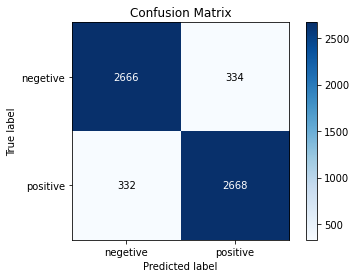

macro f1 score for data : 0.8889999876666652
micro f1 scoore for data: 0.889
hamming loss for data: 0.111
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.89      0.89      0.89      3000
    positive       0.89      0.89      0.89      3000

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000

Test  auc 0.9550388888888888
Train auc 0.9999999999999999


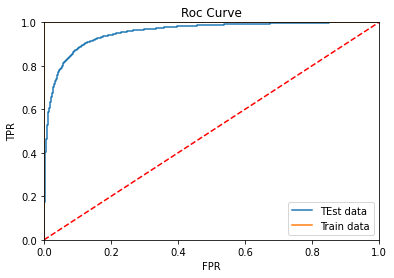

In [288]:
testingmodel_l1(tfidf_train,tfidf_test,y_train,y_test,optimal_c=1)

Test data report
Best c 1000


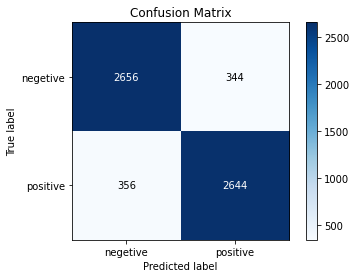

macro f1 score for data : 0.8833328666647999
hamming loss for data: 0.11666666666666667
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.88      0.89      0.88      3000
    positive       0.88      0.88      0.88      3000

    accuracy                           0.88      6000
   macro avg       0.88      0.88      0.88      6000
weighted avg       0.88      0.88      0.88      6000

Test  auc 0.9490538888888889
Train auc 1.0


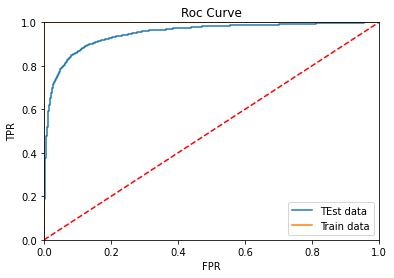

In [289]:
testingmodel_l2(tfidf_train,tfidf_test,y_train,y_test,optimal_c=1000)

# **AVG W2V**

In [290]:
list_of_sent_train=[]

for sent in X_train:
  filtered_sentence=[]
  sent=cleanhtml(sent)
  for w in sent.split():
    for cleanword in cleanpunc(w).split():
      if (cleanword.isalpha()):
        filtered_sentence.append(cleanword.lower())
      else:
        continue
  list_of_sent_train.append(filtered_sentence)

In [291]:
list_of_sent_test=[]

for sent in X_test:
  filtered_sentence=[]
  sent=cleanhtml(sent)
  for w in sent.split():
    for cleanword in cleanpunc(w).split():
      if (cleanword.isalpha()):
        filtered_sentence.append(cleanword.lower())
      else:
        continue
  list_of_sent_test.append(filtered_sentence)

In [292]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
w2v_words=list(w2v_model.wv.vocab)

In [293]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
  sent_vec = np.zeros(50) # as word vectors are of zero length
  cnt_words =0; # num of words with a valid vector in the sentence/review
  for word in sent: # for each word in a review/sentence
    if word in w2v_words:
      vec = w2v_model.wv[word]
      sent_vec += vec
      cnt_words += 1
  if cnt_words != 0:
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)        

In [294]:
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

14000
50


In [295]:
w2v_model1=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=50,workers=4)
w2v_words1=list(w2v_model1.wv.vocab)

In [296]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
  sent_vec = np.zeros(50) # as word vectors are of zero length
  cnt_words =0; # num of words with a valid vector in the sentence/review
  for word in sent: # for each word in a review/sentence
    if word in w2v_words1:
      vec = w2v_model1.wv[word]
      sent_vec += vec
      cnt_words += 1
  if cnt_words != 0:
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)  

In [297]:
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


6000
50


In [298]:
train_avgw2v=sent_vectors_train
test_avgw2v=sent_vectors_test

In [299]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

train_avgw2v=sc.fit_transform(train_avgw2v)
test_avgw2v=sc.transform(test_avgw2v)

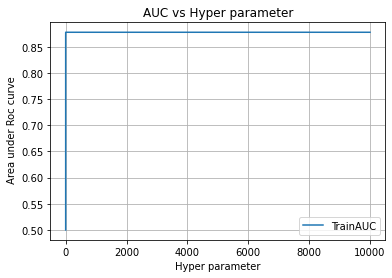

 optimal C is 1 with best roc score is 0.6922510000000001


In [300]:
logistic_l1(train_avgw2v,test_avgw2v,y_train,y_test)

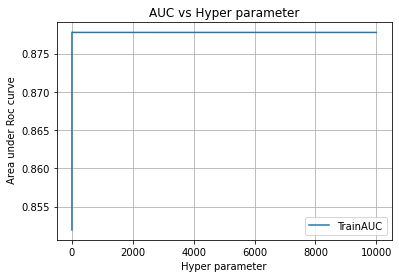

 optimal C is 1 with best roc score is 0.6922751111111112


1

In [301]:
logistic_l2(train_avgw2v,test_avgw2v,y_train,y_test)

Test data report
Best c 1


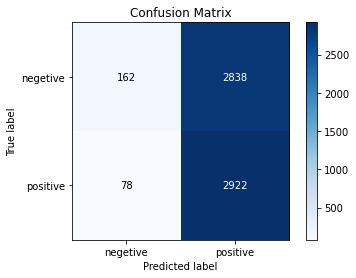

macro f1 score for data : 0.3835616438356164
micro f1 scoore for data: 0.514
hamming loss for data: 0.486
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.68      0.05      0.10      3000
    positive       0.51      0.97      0.67      3000

    accuracy                           0.51      6000
   macro avg       0.59      0.51      0.38      6000
weighted avg       0.59      0.51      0.38      6000

Test  auc 0.6933884444444445
Train auc 0.8802137551020407


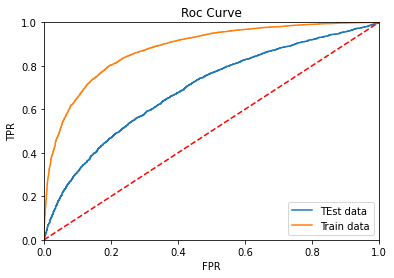

In [302]:
testingmodel_l1(train_avgw2v,test_avgw2v,y_train,y_test,optimal_c=1)

Test data report
Best c 1


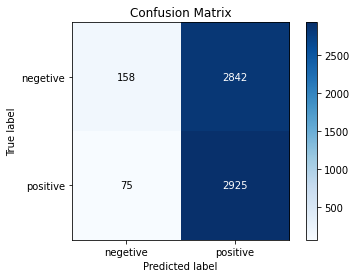

macro f1 score for data : 0.3825085219080875
micro f1 scoore for data: 0.5138333333333334
hamming loss for data: 0.4861666666666667
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.68      0.05      0.10      3000
    positive       0.51      0.97      0.67      3000

    accuracy                           0.51      6000
   macro avg       0.59      0.51      0.38      6000
weighted avg       0.59      0.51      0.38      6000

Test  auc 0.6933605555555555
Train auc 0.8802131428571428


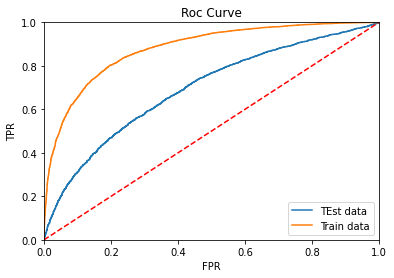

In [303]:
testingmodel_l1(train_avgw2v,test_avgw2v,y_train,y_test,optimal_c=1)

## **TF-IDF weighted W2V**

In [307]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
tfidf_train=tf_idf_vect.fit_transform(X_train)
tfidf_test=tf_idf_vect.transform(X_test)
print('Train data size',tfidf_train.shape)
print('Test data size',tfidf_test.shape)

Train data size (14000, 330723)
Test data size (6000, 330723)


In [308]:
t=tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train=[]
row=0
for sent in list_of_sent_train:
  sent_vec=np.zeros(50)
  cnt_words=0
  for word in sent:
    if word in w2v_words:
      vec=w2v_model.wv[word]
      tfidf=tfidf_train[row,t.index(word)]
      sent_vec+=(vec*tfidf)
      cnt_words+=tfidf
  if cnt_words!=0:
    tfidf_sent_vectors_train.append(sent_vec)
    row+=1


In [310]:
t=tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test=[]
row=0
for sent in list_of_sent_test:
  sent_vec=np.zeros(50)
  cnt_words=0
  for word in sent:
    try:
      if word in w2v_words1:
        vec=w2v_model1.wv[word]
        tfidf=tfidf_test[row,t.index(word)]
        sent_vec+=(vec*tfidf)
        cnt_words+=tfidf
    except:
      pass
  if cnt_words!=0:
    tfidf_sent_vectors_test.append(sent_vec)
    row+=1


In [312]:
train_tfidfw2v=tfidf_sent_vectors_train
test_tfidfw2v=tfidf_sent_vectors_test

In [313]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train_tfidfw2v=sc.fit_transform(train_tfidfw2v)
test_tfidfw2v=sc.transform(test_tfidfw2v)


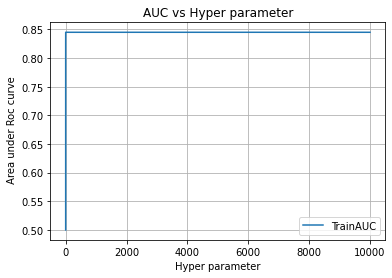

 optimal C is 1 with best roc score is 0.5749915555555556


In [314]:
logistic_l1(train_tfidfw2v,test_tfidfw2v,y_train,y_test)

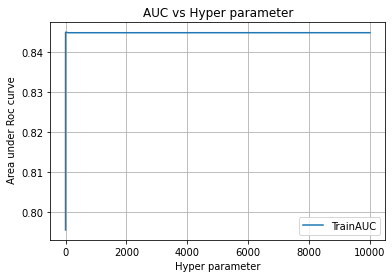

 optimal C is 1 with best roc score is 0.5737805555555556


1

In [315]:
logistic_l2(train_tfidfw2v,test_tfidfw2v,y_train,y_test)


Test data report
Best c 1


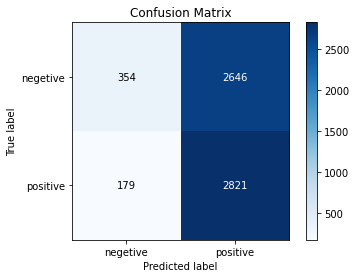

macro f1 score for data : 0.43337399111737673
micro f1 scoore for data: 0.5291666666666667
hamming loss for data: 0.4708333333333333
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.66      0.12      0.20      3000
    positive       0.52      0.94      0.67      3000

    accuracy                           0.53      6000
   macro avg       0.59      0.53      0.43      6000
weighted avg       0.59      0.53      0.43      6000

Test  auc 0.58574
Train auc 0.8484162857142857


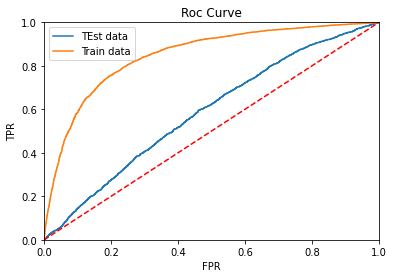

In [316]:
testingmodel_l1(train_tfidfw2v,test_tfidfw2v,y_train,y_test,optimal_c=1)

Test data report
Best c 1


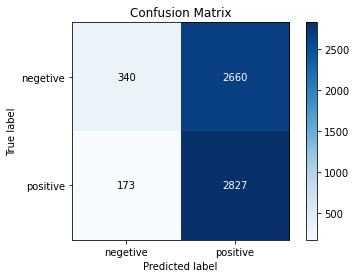

macro f1 score for data : 0.4298810548347565
hamming loss for data: 0.4721666666666667
Precision recall report for data:
               precision    recall  f1-score   support

    negetive       0.66      0.11      0.19      3000
    positive       0.52      0.94      0.67      3000

    accuracy                           0.53      6000
   macro avg       0.59      0.53      0.43      6000
weighted avg       0.59      0.53      0.43      6000

Test  auc 0.5848387777777777
Train auc 0.8484087551020408


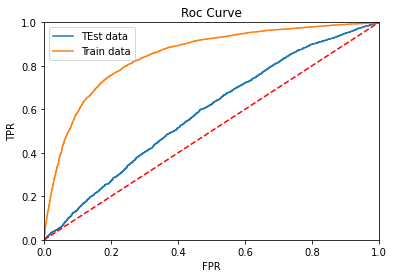

In [317]:
testingmodel_l2(train_tfidfw2v,test_tfidfw2v,y_train,y_test,optimal_c=1)

In [322]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=['Vectorizer','Regularization','Hyperparameter','Test AUC Score']
x.add_row(['BOw','L1',0.01,92.11])
x.add_row(['BOW','L2',0.0001,92.10])
x.add_row(['tfidf','L1',1,95.55])
x.add_row(['tfidf','L2',10,94.91])
x.add_row(['avgw2v','L1',1,69.33])
x.add_row(['avgw2v','L2',1,69.55])
x.add_row(['tfidfavgw2v','L1',1,69.33])
x.add_row(['tfidfavgw2v','L2',1,69.55])
print(x)

+-------------+----------------+----------------+----------------+
|  Vectorizer | Regularization | Hyperparameter | Test AUC Score |
+-------------+----------------+----------------+----------------+
|     BOw     |       L1       |      0.01      |     92.11      |
|     BOW     |       L2       |     0.0001     |      92.1      |
|    tfidf    |       L1       |       1        |     95.55      |
|    tfidf    |       L2       |       10       |     94.91      |
|    avgw2v   |       L1       |       1        |     69.33      |
|    avgw2v   |       L2       |       1        |     69.55      |
| tfidfavgw2v |       L1       |       1        |     69.33      |
| tfidfavgw2v |       L2       |       1        |     69.55      |
+-------------+----------------+----------------+----------------+
